<a href="https://colab.research.google.com/github/ywsyws/CUTIE/blob/main/CUTIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using CUTIE approach to detect total amount TTC on receipt documents

# 0. Preparation
## 0.1 Environment Setting

In [ ]:
# # Install necessary libraries
# !sudo apt install tesseract-ocr
# !pip3 install pytesseract

In [2]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Import libraries
from IPython.display import Image, display
import numpy as np
# import pytesseract

import json, re, random
from os import chdir, walk
from os.path import basename, split, join
from collections import defaultdict
import unicodedata

In [4]:
# Set root path for this project
root_path = r'/content/gdrive/MyDrive/Colab Notebooks/CUTIE/'
# Change working directory
chdir(root_path)

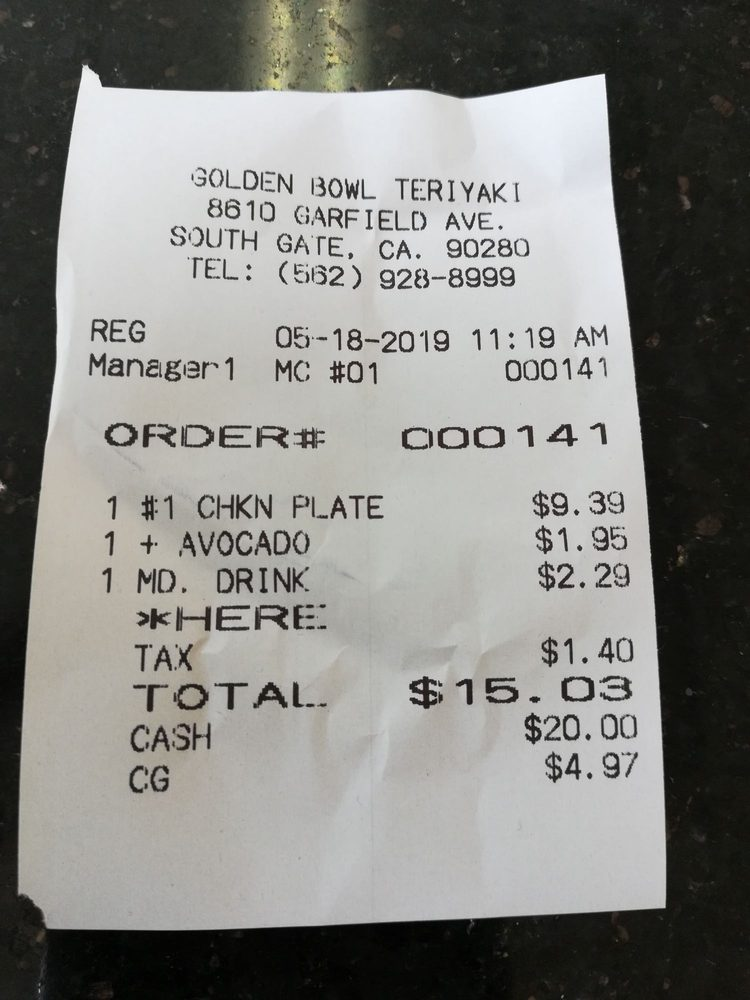

In [ ]:
# Display an image
image_name='ExpressExpenseImage/1004-receipt.jpg'
Image(filename=image_name)

## 0.2 Data Preparation
### 0.21 Capture texts on images
Stores texts and related information in json format for model training

In [ ]:
# # Display multiple images
# for file_num in range(1000, 1003):
#   image_name=f'ExpressExpenseImage/{file_num}-receipt.jpg'
#   image = Image(filename=image_name)
#   display(image)

In [ ]:
# Helper functions
def VALUES(texts):
  value_id, value_text = [], []
  for row in range(len(texts)):
    word = texts[row]["text"]
    if re.match(r'tota.|.total.|^total|totl|ttl|due$|due|$total|drv\sthru', word, re.I):
      value_id.append(texts[row]["word_id"])
      value_text.append(word)
      top = texts[row]['bbox'][1]
      for i in range(1,3):
        top_next = texts[row+1]['bbox'][1]
        top_next_2 = texts[row+2]['bbox'][1]
        if abs((top-top_next)/top_next*100) < 4:
          value_id.append(texts[row+i]["word_id"])
          value_text.append(texts[row+i]["text"])
          print(value_id, value_text) # TBD
          return value_id, value_text
        else:
          print(value_id, value_text) # TBD
          return value_id, value_text
  if value_id == []:
    print(f"Cannot find 'Total' in {image_name}")

  return value_id, value_text

In [ ]:
# for file_num in range(1000, 1020):
#   image_name=f'ExpressExpenseImage/{file_num}-receipt.jpg'

#   # Use Tesseract to localize each area of text in the input image
#   receipt = pytesseract.image_to_data(image_name, lang='eng', config='--psm 11')#custom_config

#   # Split texts into rows
#   rows = receipt.split('\n')
#   # Count number of rows in the text
#   num_of_rows = len(rows)
#   # Declare texts List to store text information
#   texts = []

#   # Get all the texts of the receipt
#   for r in range(1, num_of_rows-1):
#     # Declare words dictionary
#     words = dict()
#     # Split words in each row
#     splitted_row = rows[r].split('\t')
#     # Set id for each word
#     words['word_id'] = r
#     # Get bounding box coordinates
#     words['bbox'] = tuple([int(splitted_row[6]), int(splitted_row[7]),    # left and top
#                           int(splitted_row[6]) + int(splitted_row[8]),   # right = left + width
#                           int(splitted_row[7]) + int(splitted_row[9])])  # bottom = top + height
    
#     # Get word from each word_id
#     if len(splitted_row) < 12:
#       words['text'] = ''
#     else:
#       words['text'] = splitted_row[11]
    
#     # Write to texts List only if there is a word in that word_id
#     if words['text']:
#       texts.append(words)

#   ### Combine all the necessary information into a dictionary

#   # Declare document Dictionary
#   doc = {}
#   # Add extracted texts in the document Dictionary
#   doc.update({'text_boxes': texts})

#   # Declare classes and fields Lists
#   classes = ['O', 'TTL']
#   fields = []
#   for cl in classes:
#     if cl == 'TTL':
#       value_id, value_text = VALUES(texts)
#       # Define fields
#       new_field = {"field_name": cl, "value_id": value_id, "value_text": value_text, "key_id": [], "key_text": []}
#       fields.append(new_field)

#   # Add fields and global_attributes in the document Dictionary
#   doc.update({'fileds': fields})
#   doc.update({"global_attributes":{"file_id": basename(image_name)}})

#   # Serialize the document Dictionary into json format
#   json_file_path = f"ExpressExpenseJson/{file_num}-receipt.json"
#   with open(json_file_path, 'w') as write_file:
#     json.dump(doc, write_file, indent = 4, ensure_ascii=False)


#   # json_obj = json.dumps(doc, indent = 4, ensure_ascii=False)


[118, 122] ['TOTAL:', '51.90']
Cannot find 'Total' in ExpressExpenseImage/1001-receipt.jpg
[165, 169] ['Total', 'VP']
Cannot find 'Total' in ExpressExpenseImage/1003-receipt.jpg
[110, 114] ['TOTAL.', '$15.03']
[143, 147] ['Total', '179,94']
[116] ['Tota:']
[199, 203] ['Total', '$143.71']
[109, 110] ['TOTAL:', '$24.47']
[166, 170] ['Total', '3h']
[171] ['Total']
[152, 156] ['Total', '$64.43']
[142, 146] ['Total', '24.36']
[74, 78] ['TOTAL', '$']
Cannot find 'Total' in ExpressExpenseImage/1014-receipt.jpg
[185, 189] ['Total', '50.29']
[205, 209] ['Total', '$35.52']
[149, 153] ['Total', '11.04']
Cannot find 'Total' in ExpressExpenseImage/1018-receipt.jpg
[156, 160] ['TOTAL', '48.00']


### 0.22 Manuelly label wrong labels
All Manuelly labeled json files are stored in the "ExpressExpenseJson" folder

## 0.3 Grid table? Generation ?

In [18]:
# Set variables

random = False
data_laundry = False
encoding_factor = 1 ### ensures the size (rows/cols) of grid table compat with the network
classes = ['O', 'TTL']
update_dict=True ### default = False?
load_dictionary=False ### load dictionary from file rather than start from empty (called load_dict?)
data_split=0.75

dict_path = 'dict/ExpressExpense'
doc_path = 'ExpressExpenseJson'
doc_test_path = ''
use_cutie2 = False ### True to read image from doc_path
text_case = False ### default=True, == case sensitive
tokenize = False ### tokenize input text, default=True

# if tokenize:
#   tokenizer = tokenization.FullTokenizer('dict/vocab.txt', do_lower_case=not text_case)

rows = encoding_factor ## to be updated
cols = encoding_factor ## to be updated
segment_grid = False ### TBDeleted, Segment grid into two parts if grid is larger than cols_target
augment_strategy = 1 # 1 for increasing grid shape size, 2 for gaussian around target shape
positional_mapping_strategy = 2 # default=1
rows_segment = 72
cols_segment = 72
rows_target = 64
cols_target = 64
rows_ulimit = 80 ### handle OOM, must be multiple of encoding_factor
cols_ulimit = 80 ### handle OOM, must be multiple of encoding_factor

fill_bbox = False ### fill bbox with labels or use one single lable for the entire bbox
data_augmentation_dropout = False ### TBD: randomly dropout rows/cols
data_augmentation_extra = False ### randomly expand rows/cols
data_augmentation_extra_rows = 0 ### randomly expand rows/cols
data_augmentation_extra_cols = 0 ### randomly expand rows/cols

In [19]:
# Tune variables
# dict_path = load_dict_from_path if load_dictionary else dict_path # TBD
if load_dictionary:
    dictionary = np.load(dict_path + 'dictionary.npy').item()
    word_to_index = np.load(dict_path + 'word_to_index.npy').item()
    index_to_word = np.load(dict_path + 'index_to_word.npy').item()
else:
    dictionary = {'[PAD]':0, '[UNK]':0} ### word/counts. to be updated in load_data() and _update_docs_dictionary()
    word_to_index = {}
    index_to_word = {}

# data_split = data_split # TBD ### split data to training/validation, 0 for all for validation
data_mode = 2 # 0 to consider key and value as two different class, 1 the same class, 2 only value considered
remove_lowfreq_words = False # remove low frequency words when set as True

# num_classes = len(classes) 
# batch_size = 32        

# TBD: build a special cared dictionary
special_dict = {'*', '='} #TBDelete ### map texts to specific tokens

### 0.31 Load words and their location/class as training/validation docs and labels

In [9]:
# Construct traning document file names 
training_doc_files = []
for root,dirs,files in walk(doc_path):
            for filename in files:
                file = join(root,filename)
                training_doc_files.append(file)

In [20]:
# Helper functions
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass

    ### TBDeleted, not sure if it is necessary
    # try:
    #     unicodedata.numeric(s)
    #     return True
    # except (TypeError, ValueError):
    #     pass 
    return False


def collect_label(file_id, content):
  """
  dress and preserve only interested data.
  label_dressed in format:
  {file_id: {class: [{'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''}, ] } }
  """
  label_dressed = dict()
  label_dressed[file_id] = {cls:[] for cls in classes[1:]}
  for line in content:
    cls = line['field_name']
    if cls in classes:
      #identity = line.get('identity', 0) # TBD
      label_dressed[file_id][cls].append( {'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''} )
      label_dressed[file_id][cls][-1]['key_id'] = line.get('key_id', [])
      label_dressed[file_id][cls][-1]['value_id'] = line['value_id']
      label_dressed[file_id][cls][-1]['key_text'] = line.get('key_text', [])
      label_dressed[file_id][cls][-1]['value_text'] = line['value_text']

  # handle corrupted data
  for cls in label_dressed[file_id]: 
    for idx, label in enumerate(label_dressed[file_id][cls]):
      if len(label) == 0: # no relevant class in sample @file_id
        continue
      if (len(label['key_text'])>0 and len(label['key_id'])==0) or \
        (len(label['value_text'])>0 and len(label['value_id'])==0):
        return None
      
  return label_dressed


def dress_bbox(bbox):
  positions = np.array(bbox).reshape([-1])
  x_left = max(0, min(positions[0::2]))
  x_right = max(positions[0::2])
  y_top = max(0, min(positions[1::2]))
  y_bottom = max(positions[1::2])
  w = x_right - x_left
  h = y_bottom - y_top
  return int(x_left), int(y_top), int(x_right), int(y_bottom)


def dress_text(text, update_dict):
  """
  three cases covered: 
  alphabetic string, numeric string, special character
  """
  string = text if text_case else text.lower()
  ##### TBD
  # for i, c in enumerate(string):
  #     if is_number(c):
  #         string = string[:i] + '0' + string[i+1:]
  #####
          
  strings = [string]

  ##### TBD
  # if tokenize:
  #     strings = tokenizer.tokenize(strings[0])
      #print(string, '-->', strings)
  #####
      
  for idx, string in enumerate(strings):            
    if string.isalpha():
      if string in special_dict: ### Not sure what it does and may be can be deleted
        string = special_dict[string] ### Not sure what it does and may be can be deleted
      # TBD: convert a word to its most similar word in a known vocabulary
    elif is_number(string):
      pass
    elif len(string)==1: # special character
      pass
    else:
      # TBD: seperate string as parts for alpha and number combinated strings
      #string = re.findall('[a-z]+', string)
      pass            
    
    if string not in dictionary.keys():
      if update_dict:
        dictionary[string] = 0
      else:
        #print('unknown text: ' + string)
        string = '[UNK]' # TBD: take special care to unmet words\
    dictionary[string] += 1
    
    strings[idx] = string
  return strings


def fit_shape(shape): # modify shape size to fit the encoding factor
    while shape % encoding_factor:
        shape += 1
    return shape


def collect_data(file_id, content, update_dict):
  """
  dress and preserve only interested data.
  """          
  content_dressed = []
  left, top, right, bottom, buffer = 9999, 9999, 0, 0, 2
  for line in content:
    bbox = line['bbox'] # handle data corrupt
    if len(bbox) == 0:
      continue
    if line['text'] in special_dict: # ignore potential overlap causing characters
      continue
    
    x_left, y_top, x_right, y_bottom = dress_bbox(bbox)        
    # TBD: the real image size is better for calculating the relative x/y/w/h
    if x_left < left: left = x_left - buffer
    if y_top < top: top = y_top - buffer
    if x_right > right: right = x_right + buffer
    if y_bottom > bottom: bottom = y_bottom + buffer
    
    word_id = line['word_id']
    dressed_texts = dress_text(line['text'], update_dict)
    
    num_block = len(dressed_texts)
    for i, dressed_text in enumerate(dressed_texts): # handling tokenized text, separate bbox
      new_left = int(x_left + (x_right-x_left) / num_block * (i))
      new_right = int(x_left + (x_right-x_left) / num_block * (i+1))
      content_dressed.append([file_id, dressed_text, word_id, [new_left, y_top, new_right, y_bottom]])
      
  # initial calculation of maximum number of words in rows/cols in terms of image size
  num_words_row = [0 for _ in range(bottom)] # number of words in each row
  num_words_col = [0 for _ in range(right)] # number of words in each column
  for line in content_dressed:
    _, _, _, [x_left, y_top, x_right, y_bottom] = line
    for y in range(y_top, y_bottom):
      num_words_row[y] += 1
    for x in range(x_left, x_right):
      num_words_col[x] += 1
  max_row_words = fit_shape(max(num_words_row))
  max_col_words = 0###_fit_shape(max(num_words_col))

  # further expansion of maximum number of words in rows/cols in terms of grid shape
  max_rows = max(encoding_factor, max_row_words)
  max_cols = max(encoding_factor, max_col_words)
  DONE = False
  while not DONE:
    DONE = True
    grid_table = np.zeros([max_rows, max_cols], dtype=np.int32)
    for line in content_dressed:
      _, _, _, [x_left, y_top, x_right, y_bottom] = line
      row = int(max_rows * (y_top - top + (y_bottom-y_top)/2) / (bottom-top))
      col = int(max_cols * (x_left - left + (x_right-x_left)/2) / (right-left))
      #row = int(max_rows * (y_top + (y_bottom-y_top)/2) / (bottom))
      #col = int(max_cols * (x_left + (x_right-x_left)/2) / (right))
      #row = int(max_rows * (y_top-top) / (bottom-top))
      #col = int(max_cols * (x_left-left) / (right-left))
      #row = int(max_rows * (y_top) / (bottom))
      #col = int(max_cols * (x_left) / (right))
      #row = int(max_rows * (y_top + (y_bottom-y_top)/2) / bottom)  
      #col = int(max_cols * (x_left + (x_right-x_left)/2) / right) 
      
      while col < max_cols and grid_table[row, col] != 0: # shift to find slot to drop the current item
        col += 1
      if col == max_cols: # shift to find slot to drop the current item
        col -= 1
        ptr = 0
        while ptr<max_cols and grid_table[row, ptr] != 0:
            ptr += 1
        if ptr == max_cols: # overlap cannot be solved in current row, then expand the grid
            max_cols = fit_shape(max_cols+1) # expand shape size with step 2. ### original: _expand_shape
            DONE = False
            break
        
        grid_table[row, ptr:-1] = grid_table[row, ptr+1:]
      
      if DONE:
        if row > max_rows or col>max_cols:
          print('wrong')
        grid_table[row, col] = 1

  max_rows = fit_shape(max_rows)
  max_cols = fit_shape(max_cols)

  #print('{} collected in shape: {},{}'.format(file_id, max_rows, max_cols))

  # segment grid into two parts if number of cols is larger than cols_target
  data = []
  if segment_grid and max_cols > cols_segment: ### segment_grid=False
    content_dressed_left = []
    content_dressed_right = []
    cnt = defaultdict(int) # counter for number of words in a specific row
    cnt_l, cnt_r = defaultdict(int), defaultdict(int) # update max_cols if larger than cols_segment
    left_boundary = max_cols - cols_segment
    right_boundary = cols_segment
    for i, line in enumerate(content_dressed):
      file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom] = line
      
      row = int(max_rows * (y_top + (y_bottom-y_top)/2) / bottom)
      cnt[row] += 1                
      if cnt[row] <= left_boundary:
        cnt_l[row] += 1
        content_dressed_left.append([file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                          [left, top, right, bottom], max_rows, cols_segment])
      elif left_boundary < cnt[row] <= right_boundary:
        cnt_l[row] += 1
        cnt_r[row] += 1
        content_dressed_left.append([file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                          [left, top, right, bottom], max_rows, cols_segment])
        content_dressed_right.append([file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                          [left, top, right, bottom], max_rows, max(max(cnt_r.values()), cols_segment)])
      else:
        cnt_r[row] += 1
        content_dressed_right.append([file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                          [left, top, right, bottom], max_rows, max(max(cnt_r.values()), cols_segment)])
    #print(sorted(cnt.items(), key=lambda x:x[1], reverse=True))
    #print(sorted(cnt_l.items(), key=lambda x:x[1], reverse=True))
    #print(sorted(cnt_r.items(), key=lambda x:x[1], reverse=True))
    if max(cnt_l.values()) < 2*cols_segment:
      data.append(content_dressed_left)
    if max(cnt_r.values()) < 2*cols_segment: ### avoid OOM, which tends to happen in the right side
      data.append(content_dressed_right)
  else:
    for i, line in enumerate(content_dressed): # append height/width/numofwords to the list
      file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom] = line
      content_dressed[i] = [file_id, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                            [left, top, right, bottom], max_rows, max_cols ]
    data.append(content_dressed)
  return data


def load_data(data_files, update_dict=False):
  """
  Load words and their location/class as training/validation docs and labels 
  training_labels in format:
  {file_id: {class: [{'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''}, ] } }
  load doc words with location and class returned in format: 
  [[file_name, text, word_id, [x_left, y_top, x_right, y_bottom], [left, top, right, bottom], max_row_words, max_col_words] ]
  """

  label_dressed = {}
  doc_dressed = []
  if not data_files:
      print("no data file found.")
  for file in data_files:
    with open(file, encoding='utf-8') as f:
      data = json.load(f)
      file_id = data['global_attributes']['file_id']
      
      label = collect_label(file_id, data['fileds'])
      # ignore corrupted data
      if not label:
        continue                
      label_dressed.update(label) 
      
      data = collect_data(file_id, data['text_boxes'], update_dict)
      for i in data:
        doc_dressed.append(i)

  return doc_dressed, label_dressed

In [21]:
training_docs, training_labels = load_data(training_doc_files, update_dict = update_dict)

In [98]:
# Polish and load dictionary/word_to_index/index_to_word as file
num_words = len(dictionary)

if load_dictionary:
    max_index = len(word_to_index.keys())
    for word in dictionary:
        if word not in word_to_index:
            max_index += 1
            word_to_index[word] = max_index
            index_to_word[max_index] = word            
else:   
    word_to_index = dict(list(zip(dictionary.keys(), list(range(num_words))))) 
    index_to_word = dict(list(zip(list(range(num_words)), dictionary.keys())))

In [33]:
### TBDeleted + delete also the remove_lowfreq_words variable on top

# # assign docs words that appear less than @lower_limit times to word [UNK]
# lower_limit = 3
# if remove_lowfreq_words: 
#     for training_doc in training_docs:
#         for line in training_doc:
#             [file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
#                 [image_w, image_h], max_row_words, max_col_words] = line 
#             if dictionary[dressed_text] < lower_limit:
#                 line = [file_name, '[UNK]', word_to_index['[UNK]'], [x_left, y_top, x_right, y_bottom], \
#                         [image_w, image_h], max_row_words, max_col_words]
#                 dictionary[dressed_text] -= 1
#                 dictionary['[UNK]'] += 1

In [99]:
# save dictionary/word_to_index/index_to_word as file
np.save(dict_path + 'dictionary.npy', dictionary)
np.save(dict_path + 'word_to_index.npy', word_to_index)
np.save(dict_path + 'index_to_word.npy', index_to_word)
np.save(dict_path + 'classes.npy', classes)

In [100]:
# split training / validation docs and show statistics
num_training = int(len(training_docs)*data_split)
data_to_be_fetched = [i for i in range(len(training_docs))]
selected_training_index = data_to_be_fetched[:num_training] 
### TBDeleted + delete also the random variable on top
# if random:
#     selected_training_index = random.sample(data_to_be_fetched, num_training)
selected_validation_index = list(set(data_to_be_fetched).difference(set(selected_training_index)))
validation_docs = [training_docs[x] for x in selected_validation_index]
training_docs = [training_docs[x] for x in selected_training_index]
validation_labels = training_labels
print('\n\nDATASET: %d vocabularies, %d target classes'%(len(dictionary), len(classes)))
print('DATASET: %d for training, %d for validation'%(len(training_docs), len(validation_docs)))



DATASET: 934 vocabularies, 2 target classes
DATASET: 15 for training, 6 for validation


### 0.32 Load test files

In [118]:
# Helper functions
def cal_rows_cols(docs, extra_augmentation=False, dropout=False):                  
        max_row = encoding_factor
        max_col = encoding_factor
        for doc in docs:
            for line in doc: 
                _, _, _, _, _, max_row_words, max_col_words = line
                if max_row_words > max_row:
                    max_row = max_row_words
                if max_col_words > max_col:
                    max_col = max_col_words
        
        pre_rows = fit_shape(max_row) #(max_row//encoding_factor+1) * encoding_factor
        pre_cols = fit_shape(max_col) #(max_col//encoding_factor+1) * encoding_factor
        
        rows, cols = 0, 0
        if extra_augmentation:
            pad_row = int(random.gauss(0, da_extra_rows*encoding_factor)) #abs(random.gauss(0, u))
            pad_col = int(random.gauss(0, da_extra_cols*encoding_factor)) #random.randint(0, u)
            
            if augment_strategy == 1: # strategy 1: augment data by increasing grid shape sizes
                pad_row = abs(pad_row)
                pad_col = abs(pad_col)
                rows = fit_shape(max_row+pad_row) # apply upper boundary to avoid OOM
                cols = fit_shape(max_col+pad_col) # apply upper boundary to avoid OOM
            elif augment_strategy == 2 or augment_strategy == 3: # strategy 2: augment by increasing or decreasing the target gird shape size
                rows = fit_shape(max(rows_target+pad_row, max_row)) # protect grid shape
                cols = fit_shape(max(cols_target+pad_col, max_col)) # protect grid shape
            else:
                raise Exception('unknown augment strategy')
            rows = min(rows, rows_ulimit) # apply upper boundary to avoid OOM
            cols = min(cols, cols_ulimit) # apply upper boundary to avoid OOM                                
        else:
            rows = pre_rows
            cols = pre_cols
        return rows, cols, pre_rows, pre_cols


def shape_statistic(docs):
    res_all = defaultdict(int)
    res_row = defaultdict(int)
    res_col = defaultdict(int)
    for doc in docs:
        rows, cols, _, _ = cal_rows_cols([doc])
        res_all[rows] += 1
        res_all[cols] += 1
        res_row[rows] += 1
        res_col[cols] += 1
    res_all = sorted(res_all.items(), key=lambda x:x[0], reverse=True)
    res_row = sorted(res_row.items(), key=lambda x:x[0], reverse=True)
    res_col = sorted(res_col.items(), key=lambda x:x[0], reverse=True)
    return res_all, res_row, res_col


def data_shape_statistic():   
# def data_shape_statistic(training_docs, validation_docs, test_docs):        
        tss, tss_r, tss_c = shape_statistic(training_docs) # training shape static
        vss, vss_r, vss_c = shape_statistic(validation_docs)
        tess, tess_r, tess_c = shape_statistic(test_docs)
        print("Training statistic: ", tss)
        print("\t num: ", len(training_docs))
        print("\t rows statistic: ", tss_r)
        print("\t cols statistic: ", tss_c)
        print("\nValidation statistic: ", vss)
        print("\t num: ", len(validation_docs))
        print("\t rows statistic: ", vss_r)
        print("\t cols statistic: ", vss_c)
        print("\nTest statistic: ", tess)
        print("\t num: ", len(test_docs))
        print("\t rows statistic: ", tess_r)
        print("\t cols statistic: ", tess_c)


In [119]:
### TBDeleted + also delete the variable test_path above
# test_doc_files = _get_filenames(params.test_path) if hasattr(params, 'test_path') else []
test_doc_files = []
test_docs, test_labels = load_data(test_doc_files, update_dict=update_dict) # TBD: optimize the update dict flag
print('DATASET: %d for test from %s \n'%(len(test_docs), doc_test_path if doc_test_path else '_'))

data_shape_statistic() # show data shape static
# data_shape_statistic(training_docs, validation_docs, test_docs) # show data shape static
if len(training_docs) > 0:# adapt grid table size to all training dataset docs 
    rows, cols, _, _ = cal_rows_cols(training_docs)  
    print('\nDATASHAPE: data set with maximum grid table of ({},{}), updated.\n'.format(rows, cols))    
else:
    rows, cols = rows_ulimit, cols_ulimit

no data file found.
DATASET: 0 for test from _ 

Training statistic:  [(32, 1), (29, 1), (28, 1), (22, 1), (20, 1), (17, 2), (15, 2), (14, 4), (12, 1), (9, 1), (8, 1), (7, 3), (6, 3), (5, 4), (3, 3), (2, 1)]
	 num:  15
	 rows statistic:  [(9, 1), (8, 1), (7, 3), (6, 3), (5, 4), (3, 2), (2, 1)]
	 cols statistic:  [(32, 1), (29, 1), (28, 1), (22, 1), (20, 1), (17, 2), (15, 2), (14, 4), (12, 1), (3, 1)]

Validation statistic:  [(23, 1), (18, 1), (16, 1), (14, 1), (13, 1), (9, 1), (8, 1), (7, 2), (6, 1), (4, 2)]
	 num:  6
	 rows statistic:  [(8, 1), (7, 2), (6, 1), (4, 2)]
	 cols statistic:  [(23, 1), (18, 1), (16, 1), (14, 1), (13, 1), (9, 1)]

Test statistic:  []
	 num:  0
	 rows statistic:  []
	 cols statistic:  []

DATASHAPE: data set with maximum grid table of (9,32), updated.



In [130]:
### TBDeleted
# # Get to-be-fetched data for all the training, validation and test set
# training_data_tobe_fetched = [i for i in range(len(training_docs))]
# validation_data_tobe_fetched = [i for i in range(len(validation_docs))]        
# test_data_tobe_fetched = [i for i in range(len(test_docs))]

# 1. Train data



In [142]:
# Set variables

save_prefix = 'ExpressExpense' ### TBD: save log/models with prefix

# ckpt
restore_ckpt =False
restore_bertembedding_only = False # effective when restore_ckpt is True
embedding_file = '../graph/bert/multi_cased_L-12_H-768_A-12/bert_model.ckpt'
ckpt_path = '../graph/CUTIE/graph/'
ckpt_file = 'meals/CUTIE_highresolution_8x_d20000c9(r80c80)_iter_40000.ckpt'

# data manipulation
data_augmentation_extra = True # randomly expand rows/cols
data_augmentation_dropout = 1
data_augmentation_extra_rows = 16
data_augmentation_extra_cols = 16

# training
batch_size = 5 # Change back to 32 when I will increase the size of the training set
iterations = 40000
lr_decay_step = 13000
learning_rate = 0.0001
lr_decay_factor = 0.1

# loss optimization
hard_negative_ratio = 3 # the ratio between negative and positive losses 
use_ghm = 0 # 1 to use GHM, 0 to not use
ghm_bins = 30 ### to be tuned
ghm_momentum = 0 ### 0 / 0.75

# log
log_path = '../graph/CUTIE/log/' 
log_disp_step = 200
log_save_step = 200
validation_step = 200
test_step = 400
ckpt_save_step = 100

# model
embedding_size = 128 # not used for bert embedding which has 768 as default
weight_decay =0.0005
eps =1e-6


edges = [float(x)/ghm_bins for x in range(ghm_bins+1)]
edges[-1] += eps
acc_sum = [0.0 for _ in range(ghm_bins)]

In [24]:
 def dress_class(file_name, word_id, labels):
        """
        label_dressed in format:
        {file_id: {class: [{'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''}, ] } }
        """

        if file_name in labels:
            for cls, cls_labels in labels[file_name].items():
                for idx, cls_label in enumerate(cls_labels):
                    for key, values in cls_label.items():
                        if (key=='key_id' or key=='value_id') and word_id in values:
                            if key == 'key_id':
                                if data_mode == 0:
                                    return idx, classes.index(cls) * 2 - 1 # odd
                                elif data_mode == 1:
                                    return idx, classes.index(cls)
                                else: # ignore key_id when data_mode is not 0 or 1
                                    return 0, 0
                            elif key == 'value_id':
                                if data_mode == 0:
                                    return idx, classes.index(cls) * 2 # even 
                                else: # when data_mode is 1 or 2
                                    return idx, classes.index(cls) 
            return 0, 0 # 0 is of class type 'DontCare'
        print("No matched labels found for {}".format(file_name))

In [151]:
def positional_mapping(docs, labels, rows, cols):
    """
    docs in format:
    [[file_name, text, word_id, [x_left, y_top, x_right, y_bottom], [left, top, right, bottom], max_row_words, max_col_words] ]
    return grid_tables, gird_labels, dict bboxes {file_name:[]}, file_names
    """
    
    grid_tables = []
    gird_labels = []
    ps_indices_x = [] # positional sampling indices
    ps_indices_y = [] # positional sampling indices
    bboxes = {}
    label_mapids = []
    bbox_mapids = [] # [{}, ] bbox identifier, each id with one or multiple bbox/bboxes
    file_names = []
    for doc in docs:
        items = []
        cols_e = 2 * cols # use @cols_e larger than required @cols as buffer
        grid_table = np.zeros([rows, cols_e], dtype=np.int32)
        grid_label = np.zeros([rows, cols_e], dtype=np.int8)
        ps_x = np.zeros([rows, cols_e], dtype=np.int32)
        ps_y = np.zeros([rows, cols_e], dtype=np.int32)
        bbox = [[] for c in range(cols_e) for r in range(rows)]
        bbox_id, bbox_mapid = 0, {} # one word in one or many positions in a bbox is mapped in bbox_mapid
        label_mapid = [[] for _ in range(num_classes)] # each class is connected to several bboxes (words)
        drawing_board = np.zeros([rows, cols_e], dtype=str)
        for item in doc:
            file_name = item[0]
            text = item[1]
            word_id = item[2]
            x_left, y_top, x_right, y_bottom = item[3][:]
            left, top, right, bottom = item[4][:]
            
            dict_id = word_to_index[text]                
            entity_id, class_id = dress_class(file_name, word_id, labels)
            
            bbox_id += 1
#                 if fill_bbox: # TBD: overlap avoidance
#                     top = int(rows * y_top / image_h)
#                     bottom = int(rows * y_bottom / image_h)
#                     left = int(cols * x_left / image_w)
#                     right = int(cols * x_right / image_w)
#                     grid_table[top:bottom, left:right] = dict_id  
#                     grid_label[top:bottom, left:right] = class_id  
#                      
#                     label_mapid[class_id].append(bbox_id)
#                     for row in range(top, bottom):
#                         for col in range(left, right):
#                             bbox_mapid[row*cols+col] = bbox_id
#                      
#                     for y in range(top, bottom):
#                         for x in range(left, right):
#                             bbox[y][x] = [x_left, y_top, x_right-x_left, y_bottom-y_top]
            label_mapid[class_id].append(bbox_id)    
            
            #v_c = (y_top - top + (y_bottom-y_top)/2) / (bottom-top)
            #h_c = (x_left - left + (x_right-x_left)/2) / (right-left)
            #v_c = (y_top + (y_bottom-y_top)/2) / bottom
            #h_c = (x_left + (x_right-x_left)/2) / right 
            #v_c = (y_top-top) / (bottom-top)
            #h_c = (x_left-left) / (right-left)
            #v_c = (y_top) / (bottom)
            #h_c = (x_left) / (right)
            box_y = y_top + (y_bottom-y_top)/2
            box_x = x_left # h_l is used for image feature map positional sampling
            v_c = (y_top - top + (y_bottom-y_top)/2) / (bottom-top)
            h_c = (x_left - left + (x_right-x_left)/2) / (right-left) # h_c is used for sorting items
            row = int(rows * v_c) 
            col = int(cols * h_c) 
            items.append([row, col, [box_y, box_x], [v_c, h_c], file_name, dict_id, class_id, entity_id, bbox_id, [x_left, y_top, x_right-x_left, y_bottom-y_top]])                       
        

###########
### Stop here
###########


        items.sort(key=lambda x: (x[0], x[3], x[5])) # sort according to row > h_c > bbox_id
        for item in items:
            row, col, [box_y, box_x], [v_c, h_c], file_name, dict_id, class_id, entity_id, bbox_id, box = item
            entity_class_id = entity_id*num_classes + class_id
            
            while col < cols and grid_table[row, col] != 0:
                col += 1            
            
            # pm_strategy 0: skip if overlap
            # pm_strategy 1: shift to find slot if overlap
            # pm_strategy 2: expand grid table if overlap
            if pm_strategy == 0:
                if col == cols:                     
                    print('overlap in {} row {} r{}c{}!'.
                          format(file_name, row, rows, cols))
                    #print(grid_table[row,:])
                    #print('overlap in {} <{}> row {} r{}c{}!'.
                    #      format(file_name, index_to_word[dict_id], row, rows, cols))
                else:
                    grid_table[row, col] = dict_id
                    grid_label[row, col] = entity_class_id                       
                    bbox_mapid[row*cols+col] = bbox_id                       
                    bbox[row*cols+col] = box   
            elif pm_strategy==1 or pm_strategy==2:
                ptr = 0
                if col == cols: # shift to find slot to drop the current item
                    col -= 1
                    while ptr<cols and grid_table[row, ptr] != 0:
                        ptr += 1
                    if ptr == cols:
                        grid_table[row, :-1] = grid_table[row, 1:]
                    else:
                        grid_table[row, ptr:-1] = grid_table[row, ptr+1:]
                    
                if pm_strategy == 2:
                    while col < cols_e and grid_table[row, col] != 0:
                        col += 1
                    if col > cols: # update maximum cols in current grid
                        print(grid_table[row,:col])
                        print('overlap in {} <{}> row {} r{}c{}!'.
                              format(file_name, index_to_word[dict_id], row, rows, cols))
                        cols = col
                    if col == cols_e:      
                        print('overlap!')
                
                grid_table[row, col] = dict_id
                grid_label[row, col] = entity_class_id
                ps_x[row, col] = box_x
                ps_y[row, col] = box_y
                bbox_mapid[row*cols+col] = bbox_id     
                bbox[row*cols+col] = box
            
        cols = _fit_shape(cols)
        grid_table = grid_table[..., :cols]
        grid_label = grid_label[..., :cols]
        ps_x = np.array(ps_x[..., :cols])
        ps_y = np.array(ps_y[..., :cols])
        
        if DEBUG:
            grid_visualization(file_name, grid_table, grid_label)
        
        grid_tables.append(np.expand_dims(grid_table, -1)) 
        gird_labels.append(grid_label) 
        ps_indices_x.append(ps_x)
        ps_indices_y.append(ps_y)
        bboxes[file_name] = bbox
        label_mapids.append(label_mapid)
        bbox_mapids.append(bbox_mapid)
        file_names.append(file_name)
        
    return grid_tables, gird_labels, bboxes, label_mapids, bbox_mapids, file_names, cols, ps_indices_x, ps_indices_y

In [134]:
# Helper functions
def next_batch():

    while True:
        if len(training_data_tobe_fetched) < batch_size:
            training_data_tobe_fetched = [i for i in range(len(training_docs))]            
        selected_index = random.sample(training_data_tobe_fetched, batch_size)
        training_data_tobe_fetched = list(set(training_data_tobe_fetched).difference(set(selected_index)))

        training_docs = [training_docs[x] for x in selected_index]
        
        # data augmentation in each batch if data_augmentation==True
        rows, cols, pre_rows, pre_cols = cal_rows_cols(training_docs, extra_augmentation=data_augmentation_extra, dropout=data_augmentation_dropout)
        if data_augmentation_extra:
            print('Training grid AUGMENT size: ({},{}) from ({},{})'\
                  .format(rows, cols, pre_rows, pre_cols))

        grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, updated_cols, ps_indices_x, ps_indices_y = \
            positional_mapping(training_docs, training_labels, rows, cols)   
        if updated_cols > cols:
            print('Training grid EXPAND size: ({},{}) from ({},{})'\
                  .format(rows, updated_cols, rows, cols))
            grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, _, ps_indices_x, ps_indices_y = \
                positional_mapping(training_docs, training_labels, rows, updated_cols, update_col=False)  
        
        ## load image and generate corresponding @ps_1dindices
        images, ps_1d_indices = [], []
        if use_cutie2:
            images, ps_1d_indices = _positional_sampling(doc_path, file_names, ps_indices_x, ps_indices_y, updated_cols)   
            #print("image fetched {}".format(len(images)))          
            if len(images) == batch_size:
                break
        else:
            break

    batch = {'grid_table': np.array(grid_table), 'gt_classes': np.array(gt_classes), 
              'data_image': np.array(images), 'ps_1d_indices': np.array(ps_1d_indices), # @images and @ps_1d_indices are only used for CUTIEv2
              'bboxes': bboxes, 'label_mapids': label_mapids, 'bbox_mapids': bbox_mapids,
              'file_name': file_names, 'shape': [rows,cols]}
    return batch

In [ ]:
# Handle data
num_words = max(20000, num_words) # num_words = 934
num_classes = len(classes)

for _ in range(2000):
  a = next_batch()
  # b = fetch_validation_data()